<a href="https://colab.research.google.com/github/PriRie/IAR_TG_DASHBOARD/blob/main/TRAB_IAA011_Equipe6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**TRABALHO DE IAA011 – Visão Computacional**

**Equipe 6:**
* Leandro Motta Marinho de Oliveira
* Leticia Vieira da Rocha
* Luís Henrique Paiva
* Paulo Silas Brazileiro Luiz
* Priscila Lie Kawamura
* Vinicius Natan Silva e Souza

In [4]:
# Libraries
import numpy as np, cv2, sys, pylab, matplotlib, PIL, scipy
from numpy import histogram
from scipy import stats
from PIL import Image
import matplotlib.pyplot as plt
import skimage
from skimage.feature import local_binary_pattern
from skimage import data, morphology

from skimage.transform import rotate
from skimage import data
from skimage.color import label2rgb
from skimage import data, exposure, util

from skimage.util import dtype

import os
import random

## Q1 Extração de Características

### Q1T1. Carregue a base de dados de Treino






In [3]:
from google.colab import files,drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Leitura e extração Zip - Dados de Treinamento
from google.colab import files

!unzip Train_Warwick.zip


Saving Train_Warwick.zip to Train_Warwick.zip
Archive:  Train_Warwick.zip
   creating: Train_4cls_amostra/
   creating: Train_4cls_amostra/0/
  inflating: Train_4cls_amostra/0/46_HER2_61709.png  
  inflating: Train_4cls_amostra/0/46_HER2_64186.png  
  inflating: Train_4cls_amostra/0/13_HER2_10243.png  
  inflating: Train_4cls_amostra/0/46_HER2_58961.png  
  inflating: Train_4cls_amostra/0/46_HER2_64180.png  
  inflating: Train_4cls_amostra/0/46_HER2_55795.png  
  inflating: Train_4cls_amostra/0/18_HER2_25188.png  
  inflating: Train_4cls_amostra/0/13_HER2_11145.png  
  inflating: Train_4cls_amostra/0/13_HER2_2910.png  
  inflating: Train_4cls_amostra/0/01_HER2_4962.png  
  inflating: Train_4cls_amostra/0/18_HER2_30785.png  
  inflating: Train_4cls_amostra/0/13_HER2_11144.png  
  inflating: Train_4cls_amostra/0/01_HER2_4153.png  
  inflating: Train_4cls_amostra/0/57_HER2_6110.png  
  inflating: Train_4cls_amostra/0/01_HER2_7841.png  
  inflating: Train_4cls_amostra/0/01_HER2_6435.png  


### Q1T2. Crie partições contendo 80% para treino e 20% para validação (atenção aos pacientes).

In [8]:
# Set the path to your data
data_train = '/content/drive/MyDrive/Colab Notebooks/Visão Computacional/Train_4cls_amostra/Pasta Treino'
data_val = '/content/drive/MyDrive/Colab Notebooks/Visão Computacional/Train_4cls_amostra/Pasta Validacao'


In [36]:
def gravar_lista_imagens(data_path):
    # Lista para armazenar os caminhos das imagens

    all_files = []

    for class_folder in os.listdir(data_path):
        class_path = os.path.join(data_path, class_folder)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                if img_file.endswith('.png'):
                    file_path = os.path.join(class_path, img_file)
                    all_files.append(file_path)

    return all_files


train_files = gravar_lista_imagens(data_train)
valid_files = gravar_lista_imagens(data_val )



In [37]:
print(f"Total train images: {len(train_files)}")
print(f"Total validation images: {len(valid_files)}")

Total train images: 474
Total validation images: 119


In [ ]:
# Example: print the first few file paths in train and test sets
print("Train files:", train_files[:5])
print("Validation files:", valid_files[:5])

Train files: ['/content/drive/MyDrive/Colab Notebooks/Visão Computacional/Train_4cls_amostra/Pasta Treino/0/13_HER2_10494.png', '/content/drive/MyDrive/Colab Notebooks/Visão Computacional/Train_4cls_amostra/Pasta Treino/0/18_HER2_26007.png', '/content/drive/MyDrive/Colab Notebooks/Visão Computacional/Train_4cls_amostra/Pasta Treino/0/13_HER2_11143.png', '/content/drive/MyDrive/Colab Notebooks/Visão Computacional/Train_4cls_amostra/Pasta Treino/0/18_HER2_22090.png', '/content/drive/MyDrive/Colab Notebooks/Visão Computacional/Train_4cls_amostra/Pasta Treino/0/13_HER2_11904.png']
Validation files: ['/content/drive/MyDrive/Colab Notebooks/Visão Computacional/Train_4cls_amostra/Pasta Validacao/0/01_HER2_5769.png', '/content/drive/MyDrive/Colab Notebooks/Visão Computacional/Train_4cls_amostra/Pasta Validacao/0/01_HER2_5144.png', '/content/drive/MyDrive/Colab Notebooks/Visão Computacional/Train_4cls_amostra/Pasta Validacao/0/01_HER2_4163.png', '/content/drive/MyDrive/Colab Notebooks/V

In [ ]:
# Testing if the split into train and validation worked
def check_patient_overlap(train_list, valid_list):
    # Extract the patient IDs from the train and test lists
    train_patients = set([os.path.basename(file).split('_')[0] for file in train_list])
    valid_patients = set([os.path.basename(file).split('_')[0] for file in valid_list])

    # Find the common patient IDs in both lists
    overlap = train_patients.intersection(valid_patients)

    # Check if there's any overlap
    if overlap:
        return f"Patients in both train and validation sets: {sorted(list(overlap))}"
    else:
        return "No patients are present in both train and validation sets."

result = check_patient_overlap(train_files, valid_files)
print(result)

No patients are present in both train and validation sets.


### Q1T3.1 Extraia características utilizando LBP (gerando um csv).

In [24]:
## Extracting LBP characteristics for train and validation and saving to file
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from skimage import morphology
import csv

# Funções de extração adaptadas
def lbp_riu(npmat_img, label):
    radius = 1
    n_points = 8
    lbp = local_binary_pattern(npmat_img, n_points, radius, method='uniform')

    array_lbp = np.zeros(11, dtype=int)  # Dez posições do P+2 e mais uma para o label
    rows, cols = npmat_img.shape
    for ci in range(rows):
        for cj in range(cols):
            aux = int(lbp[ci][cj])
            array_lbp[aux + 1] += 1

    array_lbp[0] = label  # Label da imagem (agora um número)
    return array_lbp  # Retorna os vetores extraídos

def lbp_tophat(npmat_img, label):
    radius = 1
    n_points = 8
    lbp = local_binary_pattern(npmat_img, n_points, radius, method='uniform')

    array_lbp = np.zeros(11, dtype=int)  # Dez posições do P+2 e mais uma para o label
    rows, cols = npmat_img.shape
    for ci in range(rows):
        for cj in range(cols):
            aux = int(lbp[ci][cj])
            array_lbp[aux + 1] += 1

    se = morphology.disk(5)
    white = morphology.white_tophat(npmat_img, se)
    black = morphology.black_tophat(npmat_img, se)
    wmean = np.mean(white)
    wsd = np.std(white)
    bmean = np.mean(black)
    bsd = np.std(black)

    top_hat_features = np.array([wmean, wsd, bmean, bsd])
    # return np.concatenate((array_lbp, top_hat_features))  # Combina as características LBP e tophat
    return array_lbp, top_hat_features

def tophat(npmat_img, label):
    se = morphology.disk(5)
    white = morphology.white_tophat(npmat_img, se)
    black = morphology.black_tophat(npmat_img, se)
    wmean = np.mean(white)
    wsd = np.std(white)
    bmean = np.mean(black)
    bsd = np.std(black)

    top_hat_features = np.array([label, wmean, wsd, bmean, bsd])
    return top_hat_features  # Retorna as características extraídas

# Função para calcular características e salvar em CSV
def Calcula_caracteristicas(file_list, csv_name):
    with open(csv_name, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)

        for image_path in file_list:

            file_name = os.path.basename(image_path)
            class_label = int(os.path.basename(os.path.dirname(image_path)))
            img = cv2.imread(image_path, 0)

            if img is not None:
                lbp_features = lbp_riu(img, class_label)
                lbp_tophat_features, tophat_features1 = lbp_tophat(img, class_label)
                tophat_features2 = tophat(img, class_label)

                header = [ 'Nome do Arquivo','Label'] + [f'LBP_{i}' for i in range(1, 11)] + \
                         [f'TopHat_wmean', f'TopHat_wsd', f'TopHat_bmean', f'TopHat_bsd'] + \
                         [f'LBP_TopHat_{i}' for i in range(1, 11)] + \
                         [f'TopHat_wmean2', f'TopHat_wsd2', f'TopHat_bmean2', f'TopHat_bsd2']

                # Grave o cabeçalho apenas na primeira iteração
                if image_path == file_list[0]:
                    csv_writer.writerow(header)

                # Combine all features
                combined_features = np.concatenate(([file_name], # Include filename here
                    lbp_features,
                    tophat_features1,
                    lbp_tophat_features[1:],  # Exclude the label
                    tophat_features2[1:]  # Exclude the label
                ))

                csv_writer.writerow(combined_features)



In [ ]:
# Chamando para os datasets de treino e teste
Calcula_caracteristicas(train_files, 'train_lbp_features.csv')
Calcula_caracteristicas(valid_files, 'valid_lbp_features.csv')

print("Extração de características LBP e TopHat concluída e salva nos arquivos CSV.")

Extração de características LBP e TopHat concluída e salva nos arquivos CSV.


### Q1T3.2 Extraia características utilizando CNN VGG16 (gerando um csv ).

In [ ]:
!pip install keras

In [ ]:
!pip install --upgrade tensorflow

In [ ]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder

def carregar_dados_imagens(diretorio_imagens):


    imagens = []
    rotulos = []
    pacientes = []

    for classe in os.listdir(diretorio_imagens):
        caminho_classe = os.path.join(diretorio_imagens, classe)
        for imagem in os.listdir(caminho_classe):
            if imagem.endswith('.png'):
                caminho_completo = os.path.join(caminho_classe, imagem)

                # Extrair ID do paciente
                partes = imagem.split('_')
                id_paciente = partes[0]

                # Carregar a imagem
                img = cv2.imread(caminho_completo)
                img = img.astype('float32')

                # Adicionar aos arrays
                imagens.append(img)
                rotulos.append(classe)
                pacientes.append(id_paciente)

    return np.array(imagens), np.array(rotulos), np.array(pacientes)

def label_encoder(rotulos):
    label_encoder = LabelEncoder()
    rotulos_encoded = label_encoder.fit_transform(rotulos)
    return rotulos_encoded


In [ ]:
imagens_treino, rotulos_treino, pacientes_treino = carregar_dados_imagens(data_train)
imagens_val, rotulos_val, pacientes_val = carregar_dados_imagens(data_val)

In [25]:
#validação
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
import numpy as np
import pandas as pd

def treino(imagens, rotulos, pacientes,nome_arquivo):
    # Normalizar as imagens para o intervalo [0, 1]
   x_treino_normalizado = imagens_treino / 255.0
# Carregar o modelo VGG16 sem a última camada de classificação e sem pooling
   base_model = VGG16(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

# Criar um novo modelo que retorna as características da penúltima camada
   model = Model(inputs=base_model.input, outputs=base_model.output)

# Normalizar as imagens para o intervalo [0, 1]
   x_treino_normalizado = imagens / 255.0

# Extrair características usando a CNN VGG16
   features_vgg = model.predict(x_treino_normalizado)

# Criar um DataFrame com as características extraídas

   df_vgg16 = pd.DataFrame(features_vgg.reshape(features_vgg.shape[0], -1))  # Flatten para criar um DataFrame 2D
   df_vgg16['Label'] = label_encoder(rotulos)
   df_vgg16['paciente'] = pacientes  # Adicionar IDs dos pacientes
   df_vgg16.to_csv(nome_arquivo, index=False)

   return df_vgg16

In [ ]:
treino(imagens_treino, rotulos_treino, pacientes_treino, 'train_vgg16_features.csv')
treino(imagens_val, rotulos_val, pacientes_val , 'valid_vgg16_features.csv')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 383s 25s/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 1:13 25s/step

KeyboardInterrupt: 

### Q1T4. Treine modelos Random Forest, SVM e RNA para predição dos dados extraídos.

In [ ]:
# ler os arquivos train_lbp_features.csv e valid_lbp_features.csv, transformar a coluna label para inteiro, ajustar modelos RF,  RNA e SVM nos dados de treinamento e testar os ajustes nos dados de validação, mostrar matriz de confusão colorida para a performance de cada modelo nos dados de teste, salvar e mostrar um df com acurácia, sensibilidade, especificidade, F1Score, ordenar por maior F1Score

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV files
train_df_lbp = pd.read_csv('train_lbp_features.csv')
valid_df_lbp = pd.read_csv('valid_lbp_features.csv')

# Convert 'Label' column to integer type
train_df_lbp['Label'] = train_df_lbp['Label'].astype(int)
valid_df_lbp['Label'] = valid_df_lbp['Label'].astype(int)

# Separate features and labels for train and test sets
X_train_lbp = train_df_lbp.drop(columns=['Nome do Arquivo', 'Label'])
y_train_lbp = train_df_lbp['Label']
X_valid_lbp = valid_df_lbp.drop(columns=['Nome do Arquivo', 'Label'])
y_valid_lbp = valid_df_lbp['Label']

# Initialize models
rf_model_lbp = RandomForestClassifier()
rna_model_lbp = MLPClassifier()
svm_model_lbp = SVC()

# Train the models
rf_model_lbp.fit(X_train_lbp, y_train_lbp)
rna_model_lbp.fit(X_train_lbp, y_train_lbp)
svm_model_lbp.fit(X_train_lbp, y_train_lbp)

# Make predictions on the valid set
rf_pred_lbp = rf_model_lbp.predict(X_valid_lbp)
rna_pred_lbp = rna_model_lbp.predict(X_valid_lbp)
svm_pred_lbp = svm_model_lbp.predict(X_valid_lbp)

# Function to calculate metrics and create confusion matrix
def evaluate_model(y_true, y_pred_lbp, model_name):
  cm = confusion_matrix(y_true, y_pred_lbp)
  accuracy = accuracy_score(y_true, y_pred_lbp)
  tpr = recall_score(y_true, y_pred_lbp, average='weighted')
  precision = precision_score(y_true, y_pred_lbp, average='weighted')
  f1 = f1_score(y_true, y_pred_lbp, average='weighted')
  specificity = recall_score(y_true, y_pred_lbp, average='weighted')


  # Create a colored confusion matrix
  plt.figure(figsize=(6, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f'Confusion Matrix for {model_name}')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

  return accuracy, tpr, specificity, f1

# Evaluate and display confusion matrices for each model
rf_accuracy_lbp, rf_tpr_lbp, rf_specificity_lbp, rf_f1_lbp = evaluate_model(y_valid_lbp, rf_pred_lbp, 'Random Forest LBP VALID')
rna_accuracy_lbp, rna_tpr_lbp, rna_specificity_lbp, rna_f1_lbp = evaluate_model(y_valid_lbp, rna_pred_lbp, 'RNA LBP VALID')
svm_accuracy_lbp, svm_tpr_lbp, svm_specificity_lbp, svm_f1_lbp = evaluate_model(y_valid_lbp, svm_pred_lbp, 'SVM LBP VALID')

# Create a DataFrame to store the results
results_df_lbp = pd.DataFrame({
    'Model': ['Random Forest LBP VALID', 'RNA LBP VALID', 'SVM LBP VALID'],
    'Accuracy': [rf_accuracy_lbp, rna_accuracy_lbp, svm_accuracy_lbp],
    'Sensibility': [rf_tpr_lbp, rna_tpr_lbp, svm_tpr_lbp],
    'Specificity': [rf_specificity_lbp, rna_specificity_lbp, svm_specificity_lbp],
    'F1Score': [rf_f1_lbp, rna_f1_lbp, svm_f1_lbp]
})

# Sort the DataFrame by F1Score in descending order
results_df_lbp = results_df_lbp.sort_values('F1Score', ascending=False)

# Display the results
print(results_df_lbp)

In [ ]:
# Import necessary classes from scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV files
train_df_vgg = pd.read_csv('train_vgg16_features.csv')
valid_df_vgg = pd.read_csv('valid_vgg16_features.csv')

# Convert 'Label' column to integer type
train_df_vgg['Label'] = train_df_vgg['Label'].astype(int)
valid_df_vgg['Label'] = valid_df_vgg['Label'].astype(int)

# For the training set:
X_train_vgg = train_df_vgg.iloc[:, :-2]  # Select all rows, all columns except the last two
y_train_vgg = train_df_vgg['Label']

# For the validation set:
X_valid_vgg = valid_df_vgg.iloc[:, :-2]  # Same logic for validation set
y_valid_vgg = valid_df_vgg['Label']

# Initialize models
rf_model_vgg = RandomForestClassifier()
rna_model_vgg = MLPClassifier()
svm_model_vgg = SVC()

# Train the models
rf_model_vgg.fit(X_train_vgg, y_train_vgg)
rna_model_vgg.fit(X_train_vgg, y_train_vgg)
svm_model_vgg.fit(X_train_vgg, y_train_vgg)

# Make predictions on the valid set
rf_pred_vgg = rf_model_vgg.predict(X_valid_vgg)
rna_pred_vgg = rna_model_vgg.predict(X_valid_vgg)
svm_pred_vgg = svm_model_vgg.predict(X_valid_vgg)

# Function to calculate metrics and create confusion matrix
def evaluate_model(y_true, y_pred_vgg, model_name):
  cm = confusion_matrix(y_true, y_pred_vgg)
  accuracy = accuracy_score(y_true, y_pred_vgg)
  tpr = recall_score(y_true, y_pred_vgg, average='weighted')
  precision = precision_score(y_true, y_pred_vgg, average='weighted')
  f1 = f1_score(y_true, y_pred_vgg, average='weighted')
  specificity = recall_score(y_true, y_pred_vgg, average='weighted')


  # Create a colored confusion matrix
  plt.figure(figsize=(6, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f'Confusion Matrix for {model_name}')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

  return accuracy, tpr, specificity, f1

# Evaluate and display confusion matrices for each model
rf_vgg_accuracy, rf_vgg_tpr, rf_vgg_specificity, rf_vgg_f1 = evaluate_model(y_valid_vgg, rf_pred_vgg, 'Random Forest VGG16 VALID')
rna_vgg_accuracy, rna_vgg_tpr, rna_vgg_specificity, rna_vgg_f1 = evaluate_model(y_valid_vgg, rna_pred_vgg, 'RNA VGG16 VALID')
svm_vgg_accuracy, svm_vgg_tpr, svm_vgg_specificity, svm_vgg_f1 = evaluate_model(y_valid_vgg, svm_pred_vgg, 'SVM VGG16 VALID')

# Create a DataFrame to store the results
results_df_vgg = pd.DataFrame({
    'Model': ['Random Forest VGG16 VALID', 'RNA VGG16 VALID', 'SVM VGG16 VALID'],
    'Accuracy': [rf_vgg_accuracy, rna_vgg_accuracy, svm_vgg_accuracy],
    'Sensibility': [rf_vgg_tpr, rna_vgg_tpr, svm_vgg_tpr],
    'Specificity': [rf_vgg_specificity, rna_vgg_specificity, svm_vgg_specificity],
    'F1Score': [rf_vgg_f1, rna_vgg_f1, svm_vgg_f1]
})

# Sort the DataFrame by F1Score in descending order
results_df_vgg = results_df_vgg.sort_values('F1Score', ascending=False)

# Display the results
print(results_df_vgg)

In [ ]:
# prompt: juntar os dataframes de resultados acima e ordenar por maior f1score

# Concatenate the two DataFrames
combined_results_df = pd.concat([results_df_lbp, results_df_vgg], ignore_index=True)

# Sort the combined DataFrame by F1Score in descending order
combined_results_df = combined_results_df.sort_values('F1Score', ascending=False)

# Display the combined and sorted results
print(combined_results_df)


### T5 Carregue a base de Teste e execute a tarefa 3 nesta base.


In [ ]:
from google.colab import files

!unzip '/content/drive/MyDrive/Colab Notebooks/Visão Computacional/Test_Warwick.zip'

In [ ]:
# Set the path to your data
data_path = '/content/drive/MyDrive/Colab Notebooks/Visão Computacional/Test_4cl_amostra'


import os

# Dictionary to store image paths grouped by patient ID
patient_dict = {}

# List to store all image file paths
all_files = []

# Assume data_path is defined earlier in your code
# data_path = "path/to/your/data/directory"

# Loop through class folders and images to extract patient ID and store image paths
for class_folder in os.listdir(data_path):
    class_path = os.path.join(data_path, class_folder)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            if img_file.endswith('.png'):
                patient_id = img_file.split('_')[0]  # Extract the patient number XX
                full_path = os.path.join(class_path, img_file)

                # Add to patient dictionary
                if patient_id not in patient_dict:
                    patient_dict[patient_id] = []
                patient_dict[patient_id].append(full_path)

                # Add to all_files list
                all_files.append(full_path)

# Print some statistics
print(f"Total number of images: {len(all_files)}")
print(f"Number of unique patients: {len(patient_dict)}")

# If you need to use the files later in your code, you can use the all_files list
# For example:
# for file_path in all_files:
#     # Process each file
#     pass

In [ ]:
Calcula_caracteristicas(all_files, 'testfinal_lbp_features.csv')


In [ ]:
imagens_all, rotulos_all, pacientes_all =carregar_dados_imagens(data_path)
treino(imagens_all, rotulos_all, pacientes_all,'testfinal_vgg16_features.csv')


### Q1T6. Aplique os modelos treinados nos dados de teste
### Q1T7. Calcule as métricas de Sensibilidade, Especificidade e F1-Score com base em suas matrizes de confusão.


In [ ]:
test_df_lbpfinal = pd.read_csv('testfinal_lbp_features.csv')

# Convert 'Label' column to integer type
test_df_lbpfinal['Label'] = test_df_lbpfinal['Label'].astype(int)

# Separate features and labels for train and test sets
X_test_lbpfinal = test_df_lbpfinal.drop(columns=['Nome do Arquivo', 'Label'])
y_test_lbpfinal = test_df_lbpfinal['Label']

# Make predictions on the test set
rf_pred_lbpfinal = rf_model_lbp.predict(X_test_lbpfinal)
rna_pred_lbpfinal = rna_model_lbp.predict(X_test_lbpfinal)
svm_pred_lbpfinal = svm_model_lbp.predict(X_test_lbpfinal)

# Function to calculate metrics and create confusion matrix
def evaluate_model(y_true, y_pred, model_name):
  cm = confusion_matrix(y_true, y_pred)
  accuracy = accuracy_score(y_true, y_pred)
  tpr = recall_score(y_true, y_pred, average='weighted')
  precision = precision_score(y_true, y_pred, average='weighted')
  f1 = f1_score(y_true, y_pred, average='weighted')
  specificity = recall_score(y_true, y_pred, average='weighted')


  # Create a colored confusion matrix
  plt.figure(figsize=(6, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f'Confusion Matrix for {model_name}')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

  return accuracy, tpr, specificity, f1

# Evaluate and display confusion matrices for each model
rf_lbpfinal_accuracy, rf_lbpfinal_tpr, rf_lbpfinal_specificity, rf_lbpfinal_f1 = evaluate_model(y_test_lbpfinal, rf_pred_lbpfinal, 'Random Forest LBP OOT')
rna_lbpfinal_accuracy, rna_lbpfinal_tpr, rna_lbpfinal_specificity, rna_lbpfinal_f1 = evaluate_model(y_test_lbpfinal, rna_pred_lbpfinal, 'RNA LBP OOT')
svm_lbpfinal_accuracy, svm_lbpfinal_tpr, svm_lbpfinal_specificity, svm_lbpfinal_f1 = evaluate_model(y_test_lbpfinal, svm_pred_lbpfinal, 'SVM LBP OOT')

# Create a DataFrame to store the results
results_df_vggfinal = pd.DataFrame({
    'Model': ['Random Forest LBP OOT', 'RNA LBP OOT', 'SVM LBP OOT'],
    'Accuracy': [rf_lbpfinal_accuracy, rna_lbpfinal_accuracy, svm_lbpfinal_accuracy],
    'Sensibility': [rf_lbpfinal_tpr, rna_lbpfinal_tpr, svm_lbpfinal_tpr],
    'Specificity': [rf_lbpfinal_specificity, rna_lbpfinal_specificity, svm_lbpfinal_specificity],
    'F1Score': [rf_lbpfinal_f1, rna_lbpfinal_f1, svm_lbpfinal_f1]
})

# Sort the DataFrame by F1Score in descending order
results_df_lbpfinal = results_df_vggfinal.sort_values('F1Score', ascending=False)

# Display the results
print(results_df_lbpfinal)

In [ ]:
test_df_vggfinal = pd.read_csv('testfinal_vgg16_features.csv')

# Convert 'Label' column to integer type
test_df_vggfinal['Label'] = test_df_vggfinal['Label'].astype(int)

# Separate features and labels for train and test sets
X_test_vggfinal = test_df_vggfinal.iloc[:, :-2]
y_test_vggfinal = test_df_vggfinal['Label']

# Make predictions on the test set
rf_pred_vggfinal = rf_model_vgg.predict(X_test_vggfinal)
rna_pred_vggfinal = rna_model_vgg.predict(X_test_vggfinal)
svm_pred_vggfinal = svm_model_vgg.predict(X_test_vggfinal)

# Function to calculate metrics and create confusion matrix
def evaluate_model(y_true, y_pred, model_name):
  cm = confusion_matrix(y_true, y_pred)
  accuracy = accuracy_score(y_true, y_pred)
  tpr = recall_score(y_true, y_pred, average='weighted')
  precision = precision_score(y_true, y_pred, average='weighted')
  f1 = f1_score(y_true, y_pred, average='weighted')
  specificity = recall_score(y_true, y_pred, average='weighted')


  # Create a colored confusion matrix
  plt.figure(figsize=(6, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f'Confusion Matrix for {model_name}')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

  return accuracy, tpr, specificity, f1

# Evaluate and display confusion matrices for each model
rf_vggfinal_accuracy, rf_vggfinal_tpr, rf_vggfinal_specificity, rf_vggfinal_f1 = evaluate_model(y_test_vggfinal, rf_pred_vggfinal, 'Random Forest VGG16 OOT')
rna_vggfinal_accuracy, rna_vggfinal_tpr, rna_vggfinal_specificity, rna_vggfinal_f1 = evaluate_model(y_test_vggfinal, rna_pred_vggfinal, 'RNA VGG16 OOT')
svm_vggfinal_accuracy, svm_vggfinal_tpr, svm_vggfinal_specificity, svm_vggfinal_f1 = evaluate_model(y_test_vggfinal, svm_pred_vggfinal, 'SVM VGG16 OOT')

# Create a DataFrame to store the results
results_df_vggfinal = pd.DataFrame({
    'Model': ['Random Forest VGG16 OOT', 'RNA VGG16 OOT', 'SVM VGG16 OOT'],
    'Accuracy': [rf_vggfinal_accuracy, rna_vggfinal_accuracy, svm_vggfinal_accuracy],
    'Sensibility': [rf_vggfinal_tpr, rna_vggfinal_tpr, svm_vggfinal_tpr],
    'Specificity': [rf_vggfinal_specificity, rna_vggfinal_specificity, svm_vggfinal_specificity],
    'F1Score': [rf_vggfinal_f1, rna_vggfinal_f1, svm_vggfinal_f1]
})

# Sort the DataFrame by F1Score in descending order
results_df_vggfinal = results_df_vggfinal.sort_values('F1Score', ascending=False)

# Display the results
print(results_df_vggfinal)

### Q1T8. Indique qual modelo dá o melhor o resultado e a métrica utilizada


In [ ]:
# prompt: juntar os dataframes de resultados acima e ordenar por maior f1score

# Concatenate the two DataFrames
combined_results_dffinal = pd.concat([results_df_lbpfinal, results_df_vggfinal], ignore_index=True)

# Sort the combined DataFrame by F1Score in descending order
combined_results_dffinal = combined_results_dffinal.sort_values('F1Score', ascending=False)

# Display the combined and sorted results
print(combined_results_dffinal)

**RESULTADO Q1:** Os modelos SVM e Random Forest treinados com as características extraídas do modelo CNN VGG16 foram os melhores resultados por apresentarem maior F1-Score, ou seja,além de conseguir classificar corretamente maior proporção dos pacientes que realmente tinham câncer de mama, também tem a melhor especificidade ao classificar corretamente os pacientes que não têm a doença.

## Q2. Redes Neurais Artificiais

### Q2T1  Utilize a base de dados de Treino já separadas em treino e validação do exercício anterior

In [20]:
import os
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras.applications.vgg16 import VGG16
from pathlib import Path
import numpy as np
import pandas as pd

# Módulo para imprimir os gráficos de treinamento de forma dinâmica.
!pip install livelossplot

In [52]:
!pip install tensorflow==2.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

### Q2T3 Treine modelos VGG16 e Resnet50 adaptadas com e sem Data Augmentation


Data Augmentation
O ImageDataGenerator vai alterar as imagens de acordo com as transformações indicada dentro dela. Isso irá criar novas imagens com essas alterações. A quantidade de imagens é definida pelo batch_size que define para cada ciclo de retreinamento o número de imagens criadas. A opção rescale ajuda no treinamento, pois normaliza os valores da imagem entre 0 e 1.

In [ ]:
# Leitura e extração Zip - Dados de Treinamento
from google.colab import files

!unzip '/content/drive/MyDrive/Colab Notebooks/Visão Computacional/Test_Warwick.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/Visão Computacional/Test_Warwick.zip
   creating: Test_4cl_amostra/
   creating: Test_4cl_amostra/0/
  inflating: Test_4cl_amostra/0/70_HER2_23828.png  
  inflating: Test_4cl_amostra/0/70_HER2_23827.png  
  inflating: Test_4cl_amostra/0/68_HER2_13324.png  
  inflating: Test_4cl_amostra/0/73_HER2_7612.png  
  inflating: Test_4cl_amostra/0/73_HER2_4758.png  
  inflating: Test_4cl_amostra/0/66_HER2_15991.png  
  inflating: Test_4cl_amostra/0/73_HER2_6549.png  
  inflating: Test_4cl_amostra/0/68_HER2_12845.png  
  inflating: Test_4cl_amostra/0/68_HER2_18228.png  
  inflating: Test_4cl_amostra/0/66_HER2_18848.png  
  inflating: Test_4cl_amostra/0/73_HER2_5771.png  
  inflating: Test_4cl_amostra/0/66_HER2_10497.png  
  inflating: Test_4cl_amostra/0/68_HER2_18909.png  
  inflating: Test_4cl_amostra/0/66_HER2_18242.png  
  inflating: Test_4cl_amostra/0/66_HER2_10094.png  
  inflating: Test_4cl_amostra/0/68_HER2_20128.png  
  inflating: Test_4cl

In [5]:
data_teste = '/content/drive/MyDrive/Colab Notebooks/Visão Computacional/Test_4cl_amostra'
data_train = '/content/drive/MyDrive/Colab Notebooks/Visão Computacional/Train_4cls_amostra/Pasta Treino'
data_val = '/content/drive/MyDrive/Colab Notebooks/Visão Computacional/Train_4cls_amostra/Pasta Validacao'


In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

batch_size = 64

def create_generators_augmentation(train_df, valid_df, test_df):

          # Create training data generator with augmentations (optional)
    train_generator = ImageDataGenerator(
                                     rescale=1./255,
                                     rotation_range=90,
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     validation_split=0.2,
                                     preprocessing_function=preprocess_input)

    test_generator = ImageDataGenerator( preprocessing_function=preprocess_input)



    # Create training data generator
    traingen = train_generator.flow_from_dataframe(
                           train_df,
                           x_col='filename',
                           y_col='class',
                           target_size=(224,224),
                           batch_size=64,
                           class_mode='categorical',
                           classes=class_subset,
                           subset='training',
                           shuffle=True,
                           seed=42)

    # Create validation data generator
    validgen = train_generator.flow_from_dataframe(
                                                valid_df,
                                                x_col='filename',
                                                y_col='class',
                                                target_size=(224,224),
                                                batch_size=64,
                                                class_mode='categorical',
                                                classes=class_subset,
                                                subset='validation',
                                                shuffle=True,
                                                seed=42)

    testgen = test_generator.flow_from_dataframe(test_df,
                                             target_size=(224,224),
                                             batch_size=64,
                                             class_mode='categorical',
                                             classes=class_subset,
                                             shuffle=False,
                                             seed=42)


    return traingen, validgen, testgen



In [40]:
class_subset = ['0','1','2','3']

def create_dataframe(file_list):
    labels = []
    for file_path in file_list:
        # Extract the label (folder name) from the file path
        label = os.path.basename(os.path.dirname(file_path))
        labels.append(label)

    df = pd.DataFrame({
        'filename': file_list,
        'class': labels
    })

    # Convert numeric labels to strings (if necessary)
    # df['class'] = df['class'].astype(str)  # This line might be redundant if labels are already strings

    return df

train_files = gravar_lista_imagens(data_train)
valid_files = gravar_lista_imagens(data_val)
test_files = gravar_lista_imagens(data_teste)

train_df = create_dataframe(train_files)
valid_df = create_dataframe(valid_files)
test_df = create_dataframe(test_files)




In [41]:
traingen, validgen, testgen = create_generators_augmentation(train_df, valid_df, test_df)


Found 380 validated image filenames belonging to 4 classes.
Found 23 validated image filenames belonging to 4 classes.
Found 371 validated image filenames belonging to 4 classes.


Resnet treinada do zero

In [10]:
from tensorflow.keras.applications.resnet50 import ResNet50

# A opção include_top=False não inclui as camadas de aprendizado da rede original
resnet_0 = ResNet50(input_shape=(224,224,3), weights='imagenet',  include_top=False)

# treinar os pesos existentes
for layer in resnet_0.layers:
  layer.trainable = True

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Criação das camadas Fully Connected para o treinamento

In [11]:
# camadas próprias - você pode colocar mais se quiser
# A saída da resnet será a entrada da camada criada
x = Flatten()(resnet_0.output)

# camada de classificação com as 4 classes utilizadas
prediction = Dense(len(class_subset), activation='softmax')(x)

# Criação do Objeto Modelo (a parte da resnet + as camadas Fully connected criadas)
model_0 = Model(inputs=resnet_0.input, outputs=prediction)

In [23]:
model_0.summary() # Impressão das arquitetura da rede

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,989,124 (91.51 MB)

 Trainable params: 23,936,004 (91.31 MB)

 Non-trainable params: 53,120 (207.50 KB)

#### **Resnet50 com Data Augmentation**

In [14]:
%%time
# Otimizador propagação da Raiz quadrada da média ao quadrado (Root Mean Squared Propagation)
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from livelossplot import PlotLossesKeras
from tensorflow.keras.utils import to_categorical

steps_per_epoch = traingen.samples // batch_size
val_steps = validgen.samples // batch_size

n_epochs = 10

optimizer = RMSprop(learning_rate=0.0001)

model_0.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#Trainning the model
# Salva o modelo Keras após cada época, porém só o de melhor resultado
checkpointer = ModelCheckpoint(filepath='img_model_0.weights.best.keras',
                               verbose=1,
                               save_best_only=True)

# Para o treinamento para prevenir o overfitting
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')


CPU times: user 19.4 ms, sys: 0 ns, total: 19.4 ms
Wall time: 59 ms


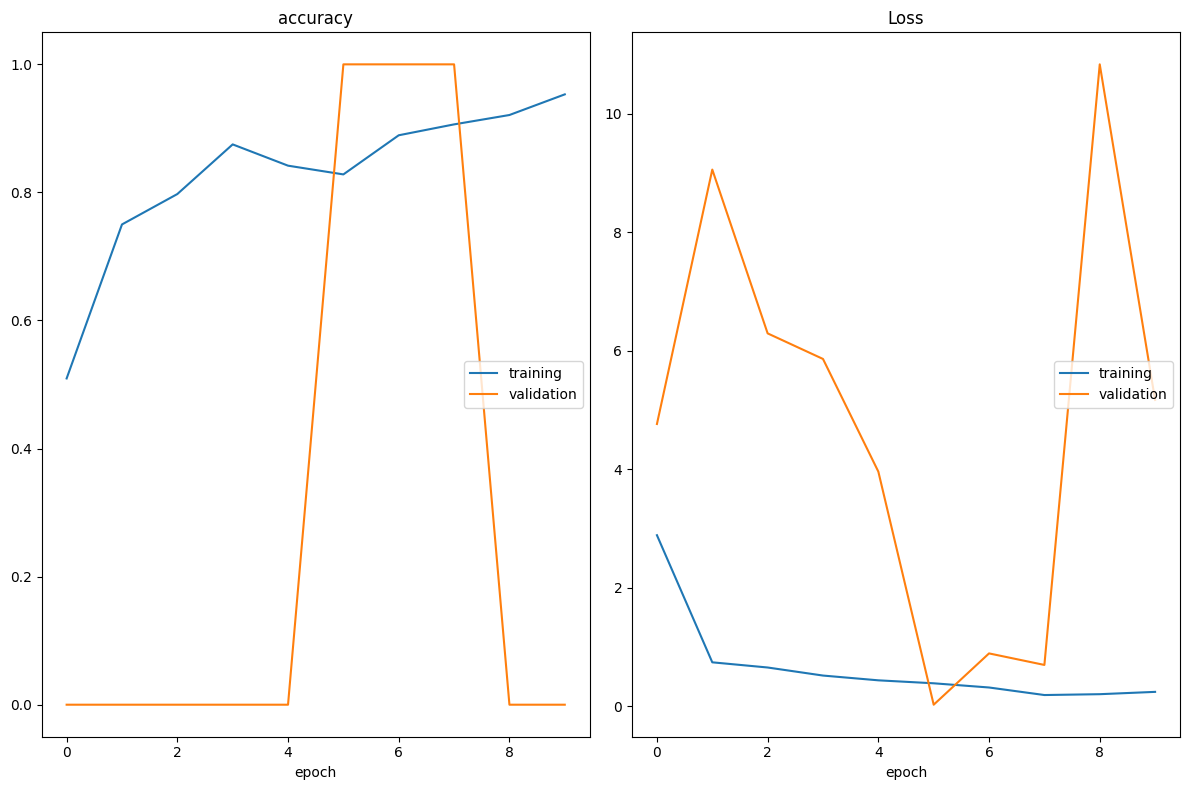

accuracy
	training         	 (min:    0.509, max:    0.953, cur:    0.953)
	validation       	 (min:    0.000, max:    1.000, cur:    0.000)
Loss
	training         	 (min:    0.189, max:    2.887, cur:    0.243)
	validation       	 (min:    0.026, max:   10.835, cur:    5.170)


In [30]:
history_0 = model_0.fit(traingen,
                    epochs=n_epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[checkpointer, PlotLossesKeras()],
                    #callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)

####Resnet sem data augmentation

In [15]:
# Utiliza os pesos treinados na base imagenet
resnet_sem_augment = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)


for layer in resnet_sem_augment.layers:
  layer.trainable = False

Criação das camadas Fully Connected para o treinamento

Rede igual ao treinamento do zero, porém utilizando os pesos da Imagenet.

In [16]:
x_sem_augment = Flatten()(resnet_sem_augment.output)

prediction = Dense(len(class_subset), activation='softmax')(x_sem_augment)

model_sem_augment = Model(inputs=resnet_sem_augment.input, outputs=prediction)

model_sem_augment.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,989,124 (91.51 MB)

 Trainable params: 401,412 (1.53 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

####Treinamento sem data augmention

In [25]:
#Gerando imagem sem data augmentation
def no_data_augmentation( train_df, valid_df):
    # Create training data generator
    train_sem_augmentation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    valid_sem_augmentation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

           # Create training data generator
    traingen = train_sem_augmentation_gen.flow_from_dataframe(
                           train_df,
                           x_col='filename',
                           y_col='class',
                           target_size=(224,224),
                           batch_size=64,
                           class_mode='categorical',
                           classes=class_subset,
                           shuffle=True,
                           seed=42)


           # Create training data generator
    validgen = train_sem_augmentation_gen.flow_from_dataframe(
                                                valid_df,
                                                x_col='filename',
                                                y_col='class',
                                                target_size=(224,224),
                                                batch_size=64,
                                                class_mode='categorical',
                                                classes=class_subset,
                                                shuffle=True,
                                                seed=42)

    return traingen, validgen

traingen, validgen= no_data_augmentation(train_df, valid_df)


Found 474 validated image filenames belonging to 4 classes.
Found 119 validated image filenames belonging to 4 classes.


In [26]:
%%time

from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from livelossplot import PlotLossesKeras
from tensorflow.keras.utils import to_categorical

steps_per_epoch = traingen.samples // batch_size
val_steps = validgen.samples // batch_size

n_epochs = 10

optimizer = RMSprop(learning_rate=0.0001)

model_sem_augment.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


checkpointer = ModelCheckpoint(filepath='img_model_sem_data_augmention.weights.best.keras',
                               verbose=1,
                               save_best_only=True)


early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')


history_tl = model_sem_augment.fit(traingen,
                    epochs=n_epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    verbose=False)

KeyboardInterrupt: 

##VGG16 com data augmentation

In [42]:
vgg_augmentation = VGG16(input_shape=(224,224,3), weights='imagenet',  include_top=False)

# treinar os pesos existentes
for layer in vgg_augmentation.layers:
  layer.trainable = False

x_vgg = Flatten()(vgg_augmentation.output)

# camada de classificação com as 04 classes utilizadas
prediction = Dense(4, activation='softmax')(x_vgg)

# Criação do Objeto Modelo
vgg_augmentation = Model(inputs=vgg_augmentation.input, outputs=prediction)

vgg_augmentation.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │         100,356 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 14,815,044 (56.51 MB)

 Trainable params: 100,356 (392.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [43]:
traingen, validgen, testgen = create_generators_augmentation(train_df, valid_df, test_df)

Found 380 validated image filenames belonging to 4 classes.
Found 23 validated image filenames belonging to 4 classes.
Found 371 validated image filenames belonging to 4 classes.


In [47]:
%%time
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from livelossplot import PlotLossesKeras
from tensorflow.keras.utils import to_categorical

steps_per_epoch = traingen.samples // batch_size
val_steps = validgen.samples // batch_size

n_epochs = 10

optimizer = RMSprop(learning_rate=0.0001)

vgg_augmentation.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Treinamento do Modelo

# Salva o modelo Keras após cada época, porém só o de melhor resultado
checkpointer = ModelCheckpoint(filepath='img_vgg_augmentation.weights.best.keras',
                               verbose=1,
                               save_best_only=True)



# Para o treinamento para prevenir o overfitting
# Não utilizei aqui, pois queria que rodasse todas as 30 épocas
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')


history_0 = vgg_augmentation.fit(traingen,
                        epochs=n_epochs,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=validgen,
                        validation_steps=val_steps,
                        verbose=True)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 435s 69s/step - accuracy: 0.3516 - loss: 1.3449 - val_accuracy: 0.0000e+00 - val_loss: 2.6007
Epoch 2/10
1/5 ━━━━━━━━━━━━━━━━━━━━ 2:55 44s/step - accuracy: 0.4688 - loss: 1.1519

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5/5 ━━━━━━━━━━━━━━━━━━━━ 85s 10s/step - accuracy: 0.4688 - loss: 1.1519 - val_accuracy: 0.0000e+00 - val_loss: 2.7931
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 277s 45s/step - accuracy: 0.4851 - loss: 1.1447 - val_accuracy: 0.0000e+00 - val_loss: 2.6939
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - accuracy: 0.5156 - loss: 1.1136 - val_accuracy: 0.0000e+00 - val_loss: 2.4073
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 230s 41s/step - accuracy: 0.4720 - loss: 1.1058 - val_accuracy: 0.0000e+00 - val_loss: 2.7353
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 78s 6s/step - accuracy: 0.5312 - loss: 1.0413 - val_accuracy: 0.0000e+00 - val_loss: 2.6997
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 326s 58s/step - accuracy: 0.4616 - loss: 1.0810 - val_accuracy: 0.0000e+00 - val_loss: 2.6317
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.4844 - loss: 1.0365 - val_accuracy: 0.0000e+00 - val_loss: 2.7627
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 223s 44s/step - accuracy: 0.5347 - loss: 1.0474 - val_accuracy: 0.0000e+

####VGG16 Sem data augmentation

In [49]:
vgg_sem_augment = VGG16(input_shape=(224,224,3), weights='imagenet',  include_top=False)

for layer in vgg_sem_augment.layers:
  layer.trainable = False

In [50]:
x_vgg_sem_augment = Flatten()(vgg_sem_augment.output)

# camada de classificação com as 04 classes utilizadas
prediction = Dense(4, activation='softmax')(x_vgg_sem_augment)

# Criação do Objeto Modelo
vgg_sem_augment = Model(inputs=vgg_sem_augment.input, outputs=prediction)

In [53]:
sem_aug_traingen, sem_aug_validgen= no_data_augmentation(train_df, valid_df)

Found 474 validated image filenames belonging to 4 classes.
Found 119 validated image filenames belonging to 4 classes.


In [ ]:
%%time
# Otimizador propagação da Raiz quadrada da média ao quadrado (Root Mean Squared Propagation)
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from livelossplot import PlotLossesKeras
from tensorflow.keras.utils import to_categorical


steps_per_epoch = traingen.samples // batch_size
val_steps = validgen.samples // batch_size

n_epochs = 10

optimizer = RMSprop(learning_rate=0.0001)

vgg_sem_augment.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


# Salva o modelo Keras após cada época, porém só o de melhor resultado
checkpointer = ModelCheckpoint(filepath='img_model_vgg_sem_augment.weights.best.keras',
                               verbose=1,
                               save_best_only=True)



# Para o treinamento para prevenir o overfitting
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')


history_vgg_sem_augment = vgg_sem_augment.fit(sem_aug_traingen,
                        epochs=n_epochs,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=sem_aug_validgen,
                        validation_steps=val_steps,
                        verbose=True)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 350s 51s/step - accuracy: 0.8313 - loss: 1.0144 - val_accuracy: 0.4844 - val_loss: 3.6898
Epoch 2/10
1/7 ━━━━━━━━━━━━━━━━━━━━ 3:32 35s/step - accuracy: 0.9062 - loss: 0.1634

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 73s 6s/step - accuracy: 0.9062 - loss: 0.1634 - val_accuracy: 0.5818 - val_loss: 3.2911
Epoch 3/10
2/7 ━━━━━━━━━━━━━━━━━━━━ 2:58 36s/step - accuracy: 0.9766 - loss: 0.1785

###Q2T3. Aplique os modelos treinados nas imagens da base de Teste

#### **Predições dos Modelos com Data Augmentation Resnet50**


In [ ]:
true_classes = testgen.classes
true_classes2 = test_df['Label']


In [ ]:
if np.array_equal(true_classes, true_classes2):
  print("true_classes é igual a true_classes2")
else:
  print("true_classes não é igual a true_classes2")

true_classes é igual a true_classes2


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np

# Função para calcular a especificidade em problemas multiclasses
def specificity_score_multiclass(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    # Inicializa a lista para armazenar a especificidade por classe
    specificity_per_class = []
    # Itera sobre cada classe para calcular a especificidade
    for i in range(len(cm)):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))  # Remove a linha e coluna da classe 'i'
        fp = np.sum(cm[:, i]) - cm[i, i]  # Falsos positivos para a classe 'i'
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Evitar divisão por zero
        specificity_per_class.append(specificity)
    # Retorna a média da especificidade sobre todas as classes
    return np.mean(specificity_per_class)

# Função para calcular todas as métricas
def calculate_metrics(true_classes, pred_classes, model_name):
    acc = accuracy_score(true_classes, pred_classes)
    sens = recall_score(true_classes, pred_classes, average='macro')  # Sensibilidade média por classe
    spec = specificity_score_multiclass(true_classes, pred_classes)  # Especificidade média por classe
    f1 = f1_score(true_classes, pred_classes, average='macro')  # F1-Score médio por classe
    return [model_name, acc, sens, spec, f1]

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np

# Carregar os pesos dos modelos
model_0.load_weights('img_model_0.weights.best.keras')

# Gerar as previsões
preds_0 = model_0.predict(testgen)
pred_classes_0 = np.argmax(preds_0, axis=1)

# Calcular as métricas para cada modelo
metrics_0 = calculate_metrics(true_classes, pred_classes_0, "Modelo ResNet50 com Data Augmentation Treinado do Zero")

# Criar DataFrame com os resultados
df_metrics = pd.DataFrame([metrics_0],
                          columns=["Modelo", "Acurácia", "Sensibilidade", "Especificidade", "F1-Score"])

# Ordenar pelo maior F1-Score
df_metrics = df_metrics.sort_values(by="F1-Score", ascending=False)

# Exibir o DataFrame ordenado
print(df_metrics)


6/6 ━━━━━━━━━━━━━━━━━━━━ 72s 12s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 65s 10s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 66s 11s/step
                                              Modelo  Acurácia  Sensibilidade  \
1  Modelo ResNet50 com Data Augmentation com Tran...  0.191375       0.191172   
2  Modelo ResNet50 com Data Augmentation com Fine...  0.247978       0.254648   
0  Modelo ResNet50 com Data Augmentation Treinado...  0.242588       0.250000   

   Especificidade  F1-Score  
1        0.730341  0.128505  
2        0.751344  0.117302  
0        0.750000  0.097614  


In [ ]:
df_metrics

,Modelo,Acurácia,Sensibilidade,Especificidade,F1-Score
1,Modelo ResNet50 com Data Augmentation com Tran...,0.191375,0.191172,0.730341,0.128505
2,Modelo ResNet50 com Data Augmentation com Fine...,0.247978,0.254648,0.751344,0.117302
0,Modelo ResNet50 com Data Augmentation Treinado...,0.242588,0.250000,0.750000,0.097614


#### **CNN VGG16 com Data Augmentation**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Definir o tamanho da imagem (mesmo que nos geradores)
img_size = (224, 224)
num_classes = len(class_subset)  # Número de classes a serem classificadas

# Carregar o modelo base VGG16 pré-treinado no ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Congelar as camadas da VGG16 para transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Adicionar camadas de classificação no topo
x = Flatten()(base_model.output)  # Achata as ativações das camadas convolucionais
x = Dense(512, activation='relu')(x)  # Primeira camada totalmente conectada
x = Dropout(0.5)(x)  # Dropout para evitar overfitting
x = Dense(num_classes, activation='softmax')(x)  # Camada de saída com número de classes

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=x)

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Definir callbacks: checkpoint para salvar o melhor modelo e early stopping
checkpoint = ModelCheckpoint('img_vgg_augmentation.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Treinar o modelo
history = model.fit(
    traingen,
    validation_data=validgen,
    epochs=10,
    steps_per_epoch=traingen.samples // traingen.batch_size,
    validation_steps=validgen.samples // validgen.batch_size,
    callbacks=[checkpoint, early_stopping]
)




Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.3228 - loss: 1.5110 
Epoch 1: val_loss improved from inf to 5.02185, saving model to vgg16_best_weights.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 217s 41s/step - accuracy: 0.3258 - loss: 1.5124 - val_accuracy: 0.0000e+00 - val_loss: 5.0218
Epoch 2/10
1/5 ━━━━━━━━━━━━━━━━━━━━ 2:14 34s/step - accuracy: 0.3607 - loss: 1.4697

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 5.02185 to 3.89308, saving model to vgg16_best_weights.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 60s 7s/step - accuracy: 0.3607 - loss: 1.4697 - val_accuracy: 0.0000e+00 - val_loss: 3.8931
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.3785 - loss: 1.4017 
Epoch 3: val_loss improved from 3.89308 to 1.21512, saving model to vgg16_best_weights.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 267s 43s/step - accuracy: 0.3869 - loss: 1.3839 - val_accuracy: 0.4783 - val_loss: 1.2151
Epoch 4/10
1/5 ━━━━━━━━━━━━━━━━━━━━ 2:26 37s/step - accuracy: 0.4688 - loss: 1.3166
Epoch 4: val_loss improved from 1.21512 to 1.16211, saving model to vgg16_best_weights.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.4688 - loss: 1.3166 - val_accuracy: 0.3043 - val_loss: 1.1621
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.4041 - loss: 1.2974 
Epoch 5: val_loss did not improve from 1.16211
5/5 ━━━━━━━━━━━━━━━━━━━━ 198s 39s/step - accuracy: 0.4009 - loss: 1.3018 - val

In [ ]:
# Carregar os melhores pesos salvos
model.load_weights('vgg16_best_weights.keras')

# Avaliar o modelo no conjunto de teste
test_loss, test_acc = model.evaluate(testgen, steps=testgen.samples // testgen.batch_size)
print(f'Acurácia no conjunto de teste: {test_acc * 100:.2f}%')


5/5 ━━━━━━━━━━━━━━━━━━━━ 184s 36s/step - accuracy: 0.6696 - loss: 6.9063
Acurácia no conjunto de teste: 58.44%


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np


# Avaliar o modelo no conjunto de teste
test_loss, test_acc = model.evaluate(testgen, steps=testgen.samples // testgen.batch_size)
print(f'Acurácia no conjunto de teste: {test_acc * 100:.2f}%')



5/5 ━━━━━━━━━━━━━━━━━━━━ 180s 36s/step - accuracy: 0.6696 - loss: 6.9063
Acurácia no conjunto de teste: 58.44%


In [ ]:
# Gerar previsões no conjunto de teste (sem o parâmetro 'steps' para prever todas as amostras)
preds = model.predict(testgen)

# Converter as previsões em classes
pred_classes = np.argmax(preds, axis=1)

# Classes verdadeiras
true_classes = testgen.classes

# Verificar se o número de previsões corresponde ao número de amostras no conjunto de teste
print(f"Número de classes verdadeiras: {len(true_classes)}")
print(f"Número de classes previstas: {len(pred_classes)}")

# Calcular métricas
acc = accuracy_score(true_classes, pred_classes)
sens = recall_score(true_classes, pred_classes, average='macro')  # Sensibilidade média
spec = specificity_score_multiclass(true_classes, pred_classes)  # Especificidade média
f1 = f1_score(true_classes, pred_classes, average='macro')  # F1-Score médio




6/6 ━━━━━━━━━━━━━━━━━━━━ 217s 36s/step
Número de classes verdadeiras: 371
Número de classes previstas: 371


In [ ]:
# Criar DataFrame com as métricas
df_metrics1 = pd.DataFrame({
    'Modelo':"VGG16 Data Augmentation",
    'Acurácia': [acc],
    'Sensibilidade': [sens],
    'Especificidade': [spec],
    'F1-Score': [f1]
})

# Exibir o DataFrame com os resultados
print(df_metrics1)

                    Modelo  Acurácia  Sensibilidade  Especificidade  F1-Score
0  VGG16 Data Augmentation  0.506739       0.492574        0.835848   0.35345


In [ ]:
# prompt: unir os dataframes df_metrics e df_metrics1 e ordenar pelo maior F1 score

# Concatenar os DataFrames df_metrics e df_metrics1
df_combined = pd.concat([df_metrics, df_metrics1], ignore_index=True)

# Ordenar o DataFrame combinado pelo maior F1-Score
df_combined = df_combined.sort_values(by='F1-Score', ascending=False)

# Exibir o DataFrame ordenado
print(df_combined)

                                              Modelo  Acurácia  Sensibilidade  \
3                            VGG16 Data Augmentation  0.506739       0.492574   
0  Modelo ResNet50 com Data Augmentation com Tran...  0.191375       0.191172   
1  Modelo ResNet50 com Data Augmentation com Fine...  0.247978       0.254648   
2  Modelo ResNet50 com Data Augmentation Treinado...  0.242588       0.250000   

   Especificidade  F1-Score  
3        0.835848  0.353450  
0        0.730341  0.128505  
1        0.751344  0.117302  
2        0.750000  0.097614  


#### **Resnet50 sem Data augmentation**

In [ ]:
# Parâmetros
img_size = (224, 224)  # Tamanho das imagens
batch_size = 64
n_epochs = 10

def test_generator_sem_augment(train_df, valid_df, test_df):
    # Geradores de dados (Data Augmentation
    train_datagen = ImageDataGenerator(rescale=1./255)  # Normalização
    valid_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
       train_df,
       x_col='filename',
       y_col='class',
       target_size=img_size,
       batch_size=batch_size,
       class_mode='categorical',  # Para múltiplas classes
       shuffle=True
    )

    valid_generator = valid_datagen.flow_from_dataframe(
       valid_df,
       x_col='filename',
       y_col='class',
       target_size=img_size,
       batch_size=batch_size,
       class_mode='categorical',
       shuffle=False
    )

    test_generator = test_datagen.flow_from_dataframe(
           test_df,
           x_col='filename',
           y_col='class',
           target_size=img_size,
           batch_size=batch_size,
           class_mode='categorical',
           shuffle=False
     )
    return train_generator, valid_generator, test_generator

In [ ]:
train_generator, valid_generator, test_generator = test_generator_sem_augment(train_df, valid_df, test_df)

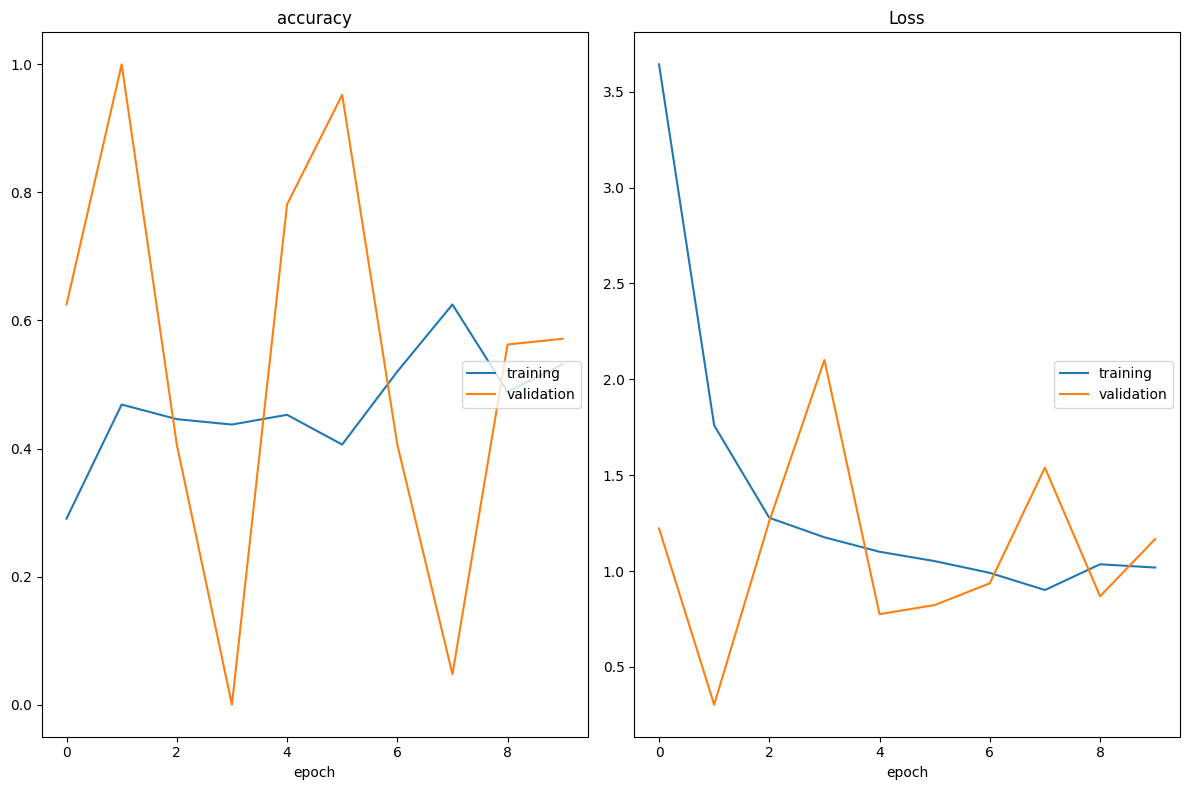

accuracy
	training         	 (min:    0.291, max:    0.625, cur:    0.531)
	validation       	 (min:    0.000, max:    1.000, cur:    0.571)
Loss
	training         	 (min:    0.901, max:    3.643, cur:    1.018)
	validation       	 (min:    0.303, max:    2.101, cur:    1.167)
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 291ms/step - accuracy: 0.5312 - loss: 1.0182 - val_accuracy: 0.5714 - val_loss: 1.1669


In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras



# Carregar o modelo ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Congelar as camadas do modelo base
for layer in base_model.layers:
    layer.trainable = False

# Adicionar camadas personalizadas
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

# Definir a camada de saída com o número correto de classes
x = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=x)

# Compilar o modelo
optimizer = RMSprop(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Definir callbacks
checkpointer = ModelCheckpoint(filepath='resnet50_best_weights.keras', verbose=1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

# Ajustar o modelo
steps_per_epoch = train_generator.samples // batch_size
val_steps = valid_generator.samples // batch_size

history = model.fit(
    train_generator,
    epochs=n_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps,
    callbacks=[checkpointer, PlotLossesKeras()],
    verbose=1
)


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np


# Gerar as previsões
preds = model.predict(testgen)
pred_classes = np.argmax(preds, axis=1)

# Calcular as métricas para cada modelo
metrics = calculate_metrics(true_classes, pred_classes, "Modelo ResNet50 sem Data Augmentation")


# Criar DataFrame com os resultados
df_metrics3 = pd.DataFrame([metrics],
                          columns=["Modelo", "Acurácia", "Sensibilidade", "Especificidade", "F1-Score"])

# Ordenar pelo maior F1-Score
df_metrics3 = df_metrics3.sort_values(by="F1-Score", ascending=False)

# Exibir o DataFrame ordenado
print(df_metrics3)


6/6 ━━━━━━━━━━━━━━━━━━━━ 72s 12s/step
                                  Modelo  Acurácia  Sensibilidade  \
0  Modelo ResNet50 sem Data Augmentation  0.242588           0.25   

   Especificidade  F1-Score  
0            0.75  0.098039  


#### **CNN VGG16 Sem Data Augmentation**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Definir o tamanho da imagem (mesmo que nos geradores)
img_size = (224, 224)
num_classes = len(class_subset)  # Número de classes a serem classificadas

# Carregar o modelo base VGG16 pré-treinado no ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Congelar as camadas da VGG16 para transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Adicionar camadas de classificação no topo
x = Flatten()(base_model.output)  # Achata as ativações das camadas convolucionais
x = Dense(512, activation='relu')(x)  # Primeira camada totalmente conectada
x = Dropout(0.5)(x)  # Dropout para evitar overfitting
x = Dense(num_classes, activation='softmax')(x)  # Camada de saída com número de classes

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=x)

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Definir callbacks: checkpoint para salvar o melhor modelo e early stopping
checkpoint = ModelCheckpoint('img_model_vgg_sem_augment.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Treinar o modelo
history = model.fit(
    traingen,
    validation_data=validgen,
    epochs=10,
    steps_per_epoch=traingen.samples // traingen.batch_size,
    validation_steps=validgen.samples // validgen.batch_size,
    callbacks=[checkpoint, early_stopping]
)




Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.2588 - loss: 1.7385 
Epoch 1: val_loss improved from inf to 4.44091, saving model to vgg16_best_weights.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 216s 43s/step - accuracy: 0.2646 - loss: 1.7278 - val_accuracy: 0.0000e+00 - val_loss: 4.4409
Epoch 2/10
1/5 ━━━━━━━━━━━━━━━━━━━━ 2:37 39s/step - accuracy: 0.3281 - loss: 1.6275

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 4.44091 to 4.20899, saving model to vgg16_best_weights.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 68s 7s/step - accuracy: 0.3281 - loss: 1.6275 - val_accuracy: 0.0000e+00 - val_loss: 4.2090
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.3690 - loss: 1.4239 
Epoch 3: val_loss improved from 4.20899 to 1.10764, saving model to vgg16_best_weights.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 260s 43s/step - accuracy: 0.3711 - loss: 1.4127 - val_accuracy: 0.5217 - val_loss: 1.1076
Epoch 4/10
1/5 ━━━━━━━━━━━━━━━━━━━━ 2:19 35s/step - accuracy: 0.2969 - loss: 1.5042
Epoch 4: val_loss improved from 1.10764 to 1.08439, saving model to vgg16_best_weights.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 61s 7s/step - accuracy: 0.2969 - loss: 1.5042 - val_accuracy: 0.5652 - val_loss: 1.0844
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.3832 - loss: 1.2358 
Epoch 5: val_loss did not improve from 1.08439
5/5 ━━━━━━━━━━━━━━━━━━━━ 199s 39s/step - accuracy: 0.3882 - loss: 1.2295 - val

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np


# Avaliar o modelo no conjunto de teste
test_loss, test_acc = model.evaluate(testgen, steps=testgen.samples // testgen.batch_size)
print(f'Acurácia no conjunto de teste: {test_acc * 100:.2f}%')

5/5 ━━━━━━━━━━━━━━━━━━━━ 185s 36s/step - accuracy: 0.6297 - loss: 6.7629
Acurácia no conjunto de teste: 50.31%


### Q2T4 Calcule as métricas de Sensibilidade, Especificidade e F1-Score com base em suas matrizes de confusão

In [ ]:
# Gerar previsões no conjunto de teste (sem o parâmetro 'steps' para prever todas as amostras)
preds = model.predict(testgen)

# Converter as previsões em classes
pred_classes = np.argmax(preds, axis=1)

# Classes verdadeiras
true_classes = testgen.classes

# Verificar se o número de previsões corresponde ao número de amostras no conjunto de teste
print(f"Número de classes verdadeiras: {len(true_classes)}")
print(f"Número de classes previstas: {len(pred_classes)}")

# Calcular métricas
acc = accuracy_score(true_classes, pred_classes)
sens = recall_score(true_classes, pred_classes, average='macro')  # Sensibilidade média
spec = specificity_score_multiclass(true_classes, pred_classes)  # Especificidade média
f1 = f1_score(true_classes, pred_classes, average='macro')  # F1-Score médio

6/6 ━━━━━━━━━━━━━━━━━━━━ 222s 35s/step
Número de classes verdadeiras: 371
Número de classes previstas: 371


In [ ]:
# Criar DataFrame com as métricas
df_metrics4 = pd.DataFrame({
    'Modelo':"VGG16 Sem Data Augmentation",
    'Acurácia': [acc],
    'Sensibilidade': [sens],
    'Especificidade': [spec],
    'F1-Score': [f1]
})

# Exibir o DataFrame com os resultados
print(df_metrics4)

                        Modelo  Acurácia  Sensibilidade  Especificidade  \
0  VGG16 Sem Data Augmentation  0.433962       0.425743        0.813095   

   F1-Score  
0   0.32121  


In [ ]:
# Concatenar os DataFrames
df_combined = pd.concat([df_metrics, df_metrics1,df_metrics3,df_metrics4], ignore_index=True)

# Ordenar o DataFrame combinado pelo maior F1-Score
df_combined = df_combined.sort_values(by='F1-Score', ascending=False)

# Exibir o DataFrame ordenado
print(df_combined)

                                              Modelo  Acurácia  Sensibilidade  \
3                            VGG16 Data Augmentation  0.506739       0.492574   
5                        VGG16 Sem Data Augmentation  0.433962       0.425743   
0  Modelo ResNet50 com Data Augmentation com Tran...  0.191375       0.191172   
1  Modelo ResNet50 com Data Augmentation com Fine...  0.247978       0.254648   
4              Modelo ResNet50 sem Data Augmentation  0.242588       0.250000   
2  Modelo ResNet50 com Data Augmentation Treinado...  0.242588       0.250000   

   Especificidade  F1-Score  
3        0.835848  0.353450  
5        0.813095  0.321210  
0        0.730341  0.128505  
1        0.751344  0.117302  
4        0.750000  0.098039  
2        0.750000  0.097614  


### Q2T5 5. Indique qual modelo dá o melhor o resultado e a métrica utilizada

**RESULTADO Q2:** O modelo que tem maior F1 score é a CNN VGG16 com data augmentation, ele tem os melhores resultados de sensibilidade, ou seja, identifica corretamente 49.25% do total de casos verdadeiros de câncer de mama do período de teste; bem com é o modelo com melhor especificidade, ou seja, identifica corretamente 83% dos casos verdadeiros de pacientes sem a doença.